In [29]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path

print(Path().cwd())
os.chdir(Path(os.getcwd()).parent)
print(Path().cwd())

/Users/samantha/QuantUS-Plugins-CEUS
/Users/samantha


## Select Contrast-Enhanced Ultrasound (CEUS) Cine and Parser

In [30]:
from src.image_loading.options import get_scan_loaders

print("Available scan loaders:", list(get_scan_loaders().keys()))

Available scan loaders: ['avi', 'nifti', 'custom_dicom', 'mp4']


In [31]:
scan_type = 'avi'

scan_path = '/Users/samantha/Desktop/ultrasound lab stuff/ctdna/p5/p5 pre/Patient #5 pre (MJL) inj1 Original Loop.avi.avi'
scan_loader_kwargs = {
    'transpose': False,
}

In [32]:
from src.entrypoints import scan_loading_step

image_data = scan_loading_step(scan_type, scan_path, **scan_loader_kwargs)

## Image Preprocessing

In [33]:
from src.image_preprocessing.options import get_im_preproc_funcs, get_required_im_preproc_kwargs

print("Available preprocessing functions:", list(get_im_preproc_funcs().keys()))

Available preprocessing functions: ['standardize', 'resample']


In [34]:
preproc_func_names = [] # in order of application
required_kwargs = get_required_im_preproc_kwargs(preproc_func_names)
print("Required kwargs for preprocessing functions:", required_kwargs)

Required kwargs for preprocessing functions: []


In [35]:
preproc_kwargs = {
    'target_vox_size': (1.0, 1.0, 1,.0),
    'interp': 'linear',
}

In [36]:
from src.entrypoints import scan_preprocessing_step

image_data = scan_preprocessing_step(preproc_func_names, image_data, **preproc_kwargs)

## Load Segmentation

Assumes same segmentation for each frame

In [37]:
from src.seg_loading.options import get_seg_loaders

print("Available segmentation loaders:", list(get_seg_loaders().keys()))

Available segmentation loaders: ['nifti', 'load_bolus_mask']


In [50]:
seg_type = 'nifti'

seg_path = '/Users/samantha/Desktop/ultrasound lab stuff/ctdna/p5/p5 pre/nifti_segmentation_QUANTUS/p5_pre_mc_roi.nii.gz'
seg_loader_kwargs = {}

In [51]:
from src.entrypoints import seg_loading_step

seg_data = seg_loading_step(seg_type, image_data, seg_path, scan_path, **seg_loader_kwargs)

## Segmentation Preprocessing

In [52]:
from src.seg_preprocessing.options import get_seg_preproc_funcs, get_required_seg_preproc_kwargs

print("Available preprocessing functions:", list(get_seg_preproc_funcs().keys()))

Available preprocessing functions: ['resample']


In [53]:
preproc_func_names = [] # in order of application
required_kwargs = get_required_seg_preproc_kwargs(preproc_func_names)
print("Required kwargs for preprocessing functions:", required_kwargs)

Required kwargs for preprocessing functions: []


In [54]:
preproc_kwargs = {
    'target_vox_size': (1.0, 1.0, 1.0),
    'interp': 'nearest',
}

In [55]:
from src.entrypoints import seg_preprocessing_step

seg_data = seg_preprocessing_step(preproc_func_names, image_data, seg_data, **preproc_kwargs)

## CEUS Quantitative Temporal Curve Analysis

In [56]:
from src.time_series_analysis.options import get_analysis_types, get_required_kwargs

all_analysis_types, all_analysis_funcs = get_analysis_types()
print("Available analysis types:", list(all_analysis_types.keys()))

Available analysis types: ['curves_paramap', 'curves']


In [57]:
analysis_type = 'curves'

print("Available analysis functions:", list(all_analysis_funcs.keys()))

Available analysis functions: ['pyradiomics', 'tic']


In [58]:
analysis_funcs = ['tic']

# Find all required kwargs for the analysis functions
analysis_funcs = analysis_funcs if len(analysis_funcs) else list(all_analysis_funcs[analysis_type].keys())
required_kwargs = get_required_kwargs(analysis_type, analysis_funcs)
print("Required kwargs for current analysis:", required_kwargs)

Required kwargs for current analysis: []


In [59]:
analysis_kwargs = {
#    # 'pyradiomics_config_paths': [
#    #     '/home/das/QuantUS_Projs/QuantUS-Plugins-CEUS/configs/pyradiomics/moderate-pselectin.yml',
#    # ],
#    # 'curves_output_path': 'test2.csv',
#    # 'binwidth': 25,
#    # 'min_intensity': 0,
 }

In [60]:
from src.entrypoints import analysis_step

analysis_obj = analysis_step(analysis_type, image_data, seg_data, analysis_funcs, **analysis_kwargs)

Computing curves:   0%|          | 0/684 [00:35<?, ?it/s]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

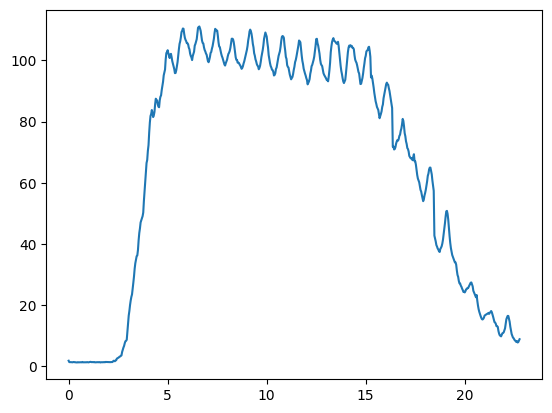

In [ ]:
import matplotlib.pyplot as plt

t = analysis_obj.time_arr
tic = analysis_obj.curves[0]['TIC']
plt.plot(t, tic)

## Curve Quantification

In [22]:
from src.curve_quantification.options import get_quantification_funcs

quantification_funcs = get_quantification_funcs()
print("Available quantification functions:", quantification_funcs.keys())

Available quantification functions: dict_keys(['auc_no_fit', 'cmus_firstorder', 'dte', 'first_order_full', 'first_order_select', 'lognormal_fit_full', 'lognormal_fit_select', 'wash_rates'])


In [23]:
function_names = [] # Empty list will use all functions
output_path = '/Users/samantha/Desktop/ultrasound lab stuff/ctdna/curve_quant_raw.csv'
curve_quantifications_kwargs = {
    'curves_to_fit': ['TIC'],
    'n_frames_to_analyze': 100,
    'tic_name': 'TIC'
}

In [24]:
from src.entrypoints import curve_quantification_step

curve_quant = curve_quantification_step(analysis_obj, function_names, output_path, **curve_quantifications_kwargs)

['auc_no_fit', 'cmus_firstorder', 'dte', 'first_order_full', 'first_order_select', 'lognormal_fit_full', 'lognormal_fit_select', 'wash_rates']
Ordered functions: ['auc_no_fit', 'lognormal_fit_full', 'lognormal_fit_select', 'cmus_firstorder', 'dte', 'first_order_full', 'first_order_select', 'wash_rates']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['auc_no_fit', 'lognormal_fit_full', 'lognormal_fit_select', 'cmus_firstorder', 'dte', 'first_order_full', 'first_order_select', 'wash_rates']


In [25]:
print(curve_quant.data_dict)
print(len(curve_quant.data_dict))
type(curve_quant.data_dict[0])

[{'Scan Name': 'p14_pre', 'Segmentation Name': 'p14_pre_mp4_roi', 'AUC_NoFit_TIC': np.float64(66.59918346067298), 'AUC_full_TIC': np.float64(84.94639872019151), 'PE_full_TIC': np.float64(1.034872800146518), 'TP_full_TIC': np.float64(27.620758876669765), 'MTT_full_TIC': np.float64(78.79132611460898), 'T0_full_TIC': np.float64(2.7856024402786774), 'Mu_full_TIC': np.float64(4.0173911518200915), 'Sigma_full_TIC': np.float64(0.8359566547344134), 'PE_Ix_full_TIC': np.int64(215), 'AUC_select_TIC': np.float64(84.94639872019151), 'PE_select_TIC': np.float64(1.034872800146518), 'TP_select_TIC': np.float64(27.620758876669765), 'MTT_select_TIC': np.float64(78.79132611460898), 'T0_select_TIC': np.float64(2.7856024402786774), 'Mu_select_TIC': np.float64(4.0173911518200915), 'Sigma_select_TIC': np.float64(0.8359566547344134), 'PE_Ix_select_TIC': np.int64(215), 'WashIn_Mean_TIC': np.float64(68.29717085173348), 'WashIn_Std_TIC': np.float64(58.18207865725336), 'WashIn_Max_TIC': np.float64(148.0053840786

dict

In [26]:
# output csv path
out_path = "/Users/samantha/Desktop/ultrasound lab stuff/ctdna/output.csv"

In [27]:
import pandas as pd
import os
from datetime import datetime

# convert dict to DataFrame row
data = curve_quant.data_dict[0]
df = pd.DataFrame([data])

scan_col = "Scan Name"  # column to check for duplicates
timestamp_col = "Timestamp"  # name of the new column
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
df[timestamp_col] = timestamp

if os.path.exists(out_path):
    # Load existing file
    existing = pd.read_csv(out_path)
    
    # If timestamp column doesn’t exist in the old file, add it
    if timestamp_col not in existing.columns:
        existing[timestamp_col] = pd.NaT
        existing.to_csv(out_path, index=False)
        print(f"Added missing '{timestamp_col}' column to {out_path}.")

    # Check schema (ignore column order differences)
    assert set(existing.columns) == set(df.columns), \
        f"Column mismatch! Existing: {existing.columns.tolist()} New: {df.columns.tolist()}"

    # Append regardless of duplicates
    df.to_csv(out_path, mode="a", header=False, index=False)
    print(f"Appended scan '{data[scan_col]}' to {out_path} at {timestamp}.")

else:
    # First time: write new file with header
    df.to_csv(out_path, index=False)
    print(f"Created {out_path} with scan '{data[scan_col]}' at {timestamp}.")

Created /Users/samantha/Desktop/ultrasound lab stuff/ctdna/output.csv with scan 'p14_pre' at 2025-10-12 21:31:03.


In [28]:
for key, value in curve_quant.data_dict[0].items():
    print(key)
    print(value)
    print()

Scan Name
p14_pre

Segmentation Name
p14_pre_mp4_roi

AUC_NoFit_TIC
66.59918346067298

AUC_full_TIC
84.94639872019151

PE_full_TIC
1.034872800146518

TP_full_TIC
27.620758876669765

MTT_full_TIC
78.79132611460898

T0_full_TIC
2.7856024402786774

Mu_full_TIC
4.0173911518200915

Sigma_full_TIC
0.8359566547344134

PE_Ix_full_TIC
215

AUC_select_TIC
84.94639872019151

PE_select_TIC
1.034872800146518

TP_select_TIC
27.620758876669765

MTT_select_TIC
78.79132611460898

T0_select_TIC
2.7856024402786774

Mu_select_TIC
4.0173911518200915

Sigma_select_TIC
0.8359566547344134

PE_Ix_select_TIC
215

WashIn_Mean_TIC
68.29717085173348

WashIn_Std_TIC
58.18207865725336

WashIn_Max_TIC
148.00538407868657

WashIn_Min_TIC
4.718928864712674

WashIn_Median_TIC
64.03321828363968

WashIn_Variance_TIC
3385.154276878817

WashIn_Skewness_TIC
0.1165265110507733

WashIn_Kurtosis_TIC
-1.7408416119416006

WashIn_Range_TIC
143.2864552139739

WashIn_InterquartileRange_TIC
126.0492794472675

WashIn_Entropy_TIC
4.6789